# Tutorial on Drawing Pictures

Intro: A manager agent controlls the search agent to collect information online and the painter_agent to paint the picture.

## Steps:
- Define the Paint action and painter Agent

- Define the Search action and search agent

- Initialize the agents and add illustration example for them.

- Build a manager agent to control the team and add illustration example for the manager.

- Begin painting !


Remember to get your own openai_api_key

In [1]:
from typing import List
from agentlite.actions import BaseAction
from agentlite.agents import ABCAgent, BaseAgent
from agentlite.llm.agent_llms import BaseLLM, get_llm_backend
from agentlite.logging.multi_agent_log import AgentLogger
from IPython.display import Image, display
import requests
from env import openai_api_key
from openai import OpenAI


## Define the Paint action and agent

In [2]:
# Define DALLE client
DALLE_client = OpenAI(api_key = openai_api_key)

# Define Paint Action
class Paint(BaseAction):
    def __init__(self) -> None:
        action_name = "PaintPicture"
        action_desc = "Using this action to paint a picture based on description."
        params_doc = {"query": "The visual description of the picture. Better optimized for DALLE model."}
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )
    
    # fetch pic from url and display it
    def fetch_and_display(self, url):
        response = requests.get(url)
        
        if response.status_code == 200:
            display(Image(response.content))
        else:
            print("Failed to fetch image from URL: ", url)


    def __call__(self, query):
        response = DALLE_client.images.generate(
            model = "dall-e-3",
            prompt = query,
            size = "1024x1024",
            quality="standard",
            n=1,
        )
        image_url = response.data[0].url
        self.fetch_and_display(image_url)

        return f"The image has been painted and displayed."
    

## using the agentrool logger to record the running log
agent_logger = AgentLogger(PROMPT_DEBUG_FLAG=False)

# Define the painter agent
class PainterAgent(BaseAgent):
    def __init__(
        self,
        llm: BaseLLM,
        actions: List[BaseAction] = [Paint()], 
        manager: ABCAgent = None,
        **kwargs
    ):
        name = "Painter_agent"
        role = """You are a painter and can draw a picture with Paint action."""
        super().__init__(
            name=name,
            role=role,
            llm=llm,
            actions=actions,
            manager=manager,
            logger=agent_logger,
        ) 


## Define the Search action and agent

In [3]:
import os
from agentlite.actions.BaseAction import BaseAction
from langchain_community.tools import DuckDuckGoSearchResults, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
# defining the ducksearch agent as an agent to use DuckSearch API from langchain
from typing import List
from agentlite.actions import BaseAction
from agentlite.agents import ABCAgent, BaseAgent
from agentlite.llm.agent_llms import BaseLLM, get_llm_backend
from agentlite.llm.LLMConfig import LLMConfig
from agentlite.logging.multi_agent_log import AgentLogger

# define the ducksearch action
class DuckSearch(BaseAction):
    def __init__(self) -> None:
        action_name = "DuckDuckGo_Search"
        action_desc = "Using this action to search online content to obtain the visual characteristic for painting."
        params_doc = {"query": "the search string for visual characteristic. be simple."}
        self.search = DuckDuckGoSearchResults()
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )

    def __call__(self, query):
        return self.search.run(query)

# define the wikipedia search action
class WikipediaSearch(BaseAction):
    def __init__(self) -> None:
        action_name = "Wikipedia_Search"
        action_desc = "Using this API to search Wiki content."
        params_doc = {"query": "the search string. be simple."}

        self.search = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )

    def __call__(self, query):
        return self.search.run(query)
    

## using the agentrool logger to record the running log
agent_logger = AgentLogger(PROMPT_DEBUG_FLAG=False)

class SearchAgent(BaseAgent):
    def __init__(
        self,
        llm: BaseLLM,
        actions: List[BaseAction] = [DuckSearch(), WikipediaSearch()], # we add both actions into agents
        manager: ABCAgent = None,
        **kwargs
    ):
        name = "search_agent"
        role = """You can research relevant information with DuckDuckGo_Search and WikipediaSearch. Summarize the visual characteristcs for the painter."""
        super().__init__(
            name=name,
            role=role,
            llm=llm,
            actions=actions,
            manager=manager,
            logger=agent_logger,
        )

## Initialize the painter agent and search agent with LLM

In [4]:
# calling the agent with TaskPackage
from agentlite.commons import AgentAct, TaskPackage
from agentlite.actions import ThinkAct, FinishAct
from agentlite.actions.InnerActions import INNER_ACT_KEY
from agentlite.agents.agent_utils import AGENT_CALL_ARG_KEY

# Initialize the backend LLM
llm_config_dict = {"llm_name": "gpt-4-32k", "temperature": 0.0, "openai_api_key": openai_api_key}
llm_config = LLMConfig(llm_config_dict)
llm = get_llm_backend(llm_config)

painter_agent = PainterAgent(llm=llm)
search_agent = SearchAgent(llm=llm)



## Add illustrative example for the two agents

In [5]:
# Add an illustration example for the search agent
exp_task = "What is the visual characteristics of Dragon?"
exp_task_pack = TaskPackage(instruction=exp_task)

act_1 = AgentAct(
    name=DuckSearch().action_name,
    params={"query": f"""Visual characteristics of Dragon"""
    },
)
obs_1 = "The Dragon is usually depicted as winged, fire-breathing monsters."

act_2 = AgentAct(
    name=WikipediaSearch().action_name,
    params={"query": "Dragon",
        },
)
obs_2 = """Dragon is a magical legendary creature that is winged, horned and capable of breathing fire."""

act_3 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "Dragon can be depicted as winged, horned, fire-breathing legendary creature."})
obs_3 = "Task Completed. Dragon can be depicted as winged, horned, fire-breathing legendary creature."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2), (act_3, obs_3)]

search_agent.prompt_gen.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)


# Add an illustration example for the painter agent
exp_task = "Draw a Dragon as winged, horned, fire-breathing legendary creature."
exp_task_pack = TaskPackage(instruction=exp_task)

act_1 = AgentAct(
    name=Paint().action_name,
    params={"query": f"""A legendary Dragon that is winged, horned and fire-breathing."""
    },
)
obs_1 = "The image has been painted and displayed."

act_2 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "The image has been painted."})
obs_2 = "Task Completed. The image has been painted and displayed."

exp_act_obs = [(act_1, obs_1), (act_2, obs_2)]

painter_agent.prompt_gen.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)


## Build the manager agent and add illustrative example

In [6]:
# define manager agent
from agentlite.agents import ManagerAgent

manager_agent_info = {
    "name": "manager_agent",
    "role": "you are controlling search_agent and painter_agent to complete the painting task. You can search related information with search_agent, and paint the picture with painter_agent."
}
team = [search_agent, painter_agent]
manager_agent = ManagerAgent(name=manager_agent_info["name"], role=manager_agent_info["role"], llm=llm, TeamAgents=team,logger=agent_logger)

# add illustration example for the manager agent

exp_task = "Paint a Dragon."
exp_task_pack = TaskPackage(instruction=exp_task)

act_1 = AgentAct(
    name=ThinkAct.action_name,
    params={INNER_ACT_KEY: f"""I can ask the search_agent to collect the visual characteristics of Dragon, and then ask painter_agent to paint the image based on collected information."""
    },
)
obs_1 = "OK"

act_2 = AgentAct(
    name=search_agent.name,
    params={AGENT_CALL_ARG_KEY: "What is the visual characteristics of Dragon?",
        },
)
obs_2 = """Dragon can be depicted as winged, horned, fire-breathing legendary creature."""

act_3 = AgentAct(
    name=painter_agent.name,
    params={AGENT_CALL_ARG_KEY: "Draw a Dragon as winged, horned, fire-breathing legendary creature.",
        },
)
obs_3 = """The Dragon is painted."""

act_4 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "I have finished the painting. Task completed."})
obs_4 = "Task Completed. The Dragon is painted and displayed."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2), (act_3, obs_3), (act_4, obs_4)]

manager_agent.prompt_gen.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)

## Begin Paining with prompt

Agent manager_agent receives the following TaskPackage:
[
	Task ID: cff4f336-36ee-423a-8296-8516283c6e7a
	Instruction: Draw the picture of Qi Lin.
]
====manager_agent starts execution on TaskPackage cff4f336-36ee-423a-8296-8516283c6e7a====


/Users/liangwei.yang/miniconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Agent manager_agent takes 0-step Action:
{
	name: Think
	params: {'response': 'I can ask the search_agent to collect the visual characteristics of Qi Lin, and then ask painter_agent to paint the image based on collected information.'}
}
Observation: OK
Agent manager_agent takes 1-step Action:
{
	name: search_agent
	params: {'Task': 'What is the visual characteristics of Qi Lin?'}
}
Agent search_agent receives the following TaskPackage:
[
	Task ID: cff4f336-36ee-423a-8296-8516283c6e7a
	Instruction: What is the visual characteristics of Qi Lin?
]
====search_agent starts execution on TaskPackage cff4f336-36ee-423a-8296-8516283c6e7a====
Agent search_agent takes 0-step Action:
{
	name: DuckDuckGo_Search
	params: {'query': 'Visual characteristics of Qi Lin'}
}


/Users/liangwei.yang/miniconda3/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:47: UserWarning: DDGS running in an async loop. This may cause errors. Use AsyncDDGS instead.
  with DDGS() as ddgs:


Observation: [snippet: ch'i-lin unicorn qilin, in Chinese mythology, the unicorn whose rare appearance often coin[TLDR]
Agent search_agent takes 1-step Action:
{
	name: Finish
	params: {'response': 'Qi Lin is a mythical animal in Chinese culture that is shaped like a dragon with one or two antlers, often referred to as the Chinese Unicorn. It is seen as a benevolent and auspicious creature that is believed to bring good luck and positivity. Its appearance is often associated with the birth or death of a sage or illustrious ruler. The Chi Lin is also known for its similarities to the Western Unicorn, and it is widely accepted in Feng Shui as a symbol of kindness and virtue.'}
}
Observation: Task Completed.
=========search_agent finish execution. TaskPackage[ID:cff4f336-36ee-423a-8296-8516283c6e7a] status:
[
	completion: completed
	answer: Qi Lin is a mythical animal in Chinese culture that is shaped like a dragon with one or two antlers, often referred to as the Chinese Unicorn. It is s

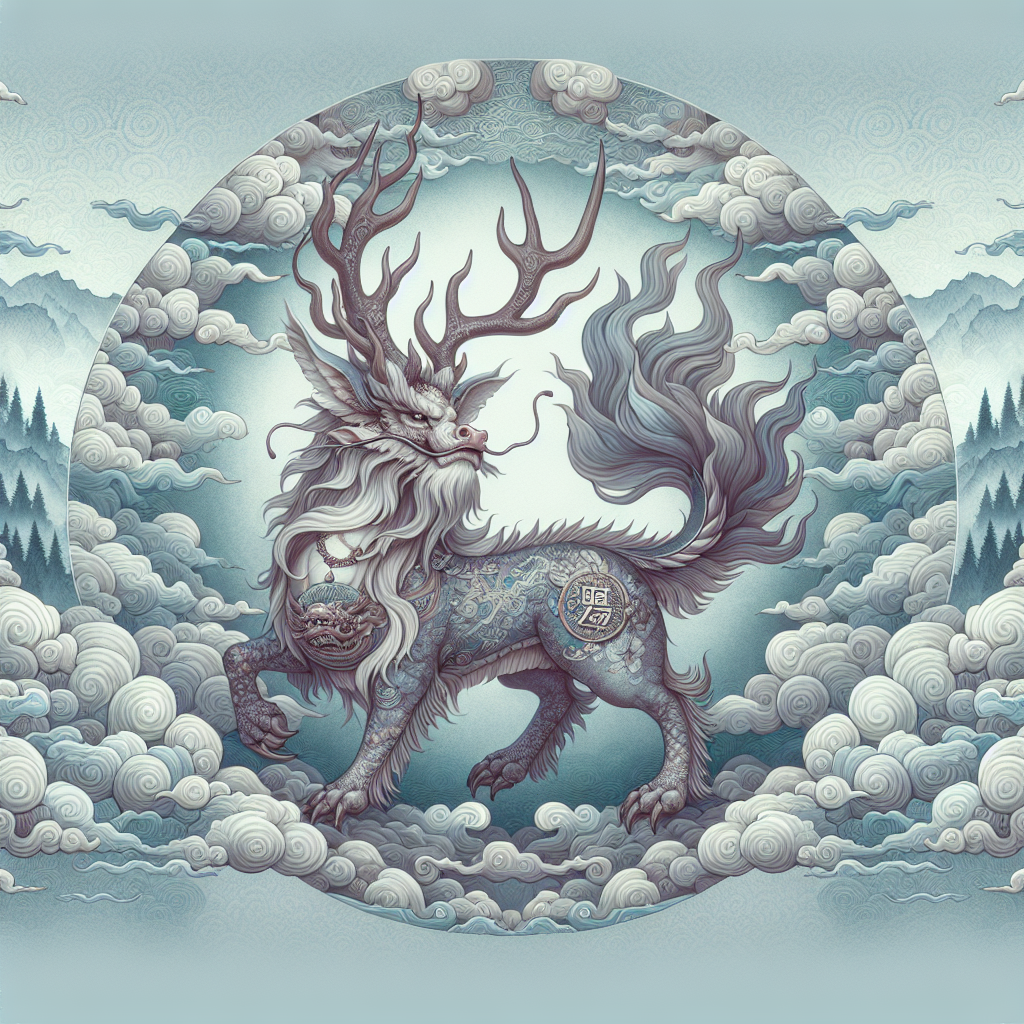

Observation: The image has been painted and displayed.
Agent Painter_agent takes 1-step Action:
{
	name: Finish
	params: {'response': 'The image has been painted.'}
}
Observation: Task Completed.
=========Painter_agent finish execution. TaskPackage[ID:cff4f336-36ee-423a-8296-8516283c6e7a] status:
[
	completion: completed
	answer: The image has been painted.
]
Observation: The image has been painted.
Agent manager_agent takes 3-step Action:
{
	name: Finish
	params: {'response': 'I have finished the painting. Task completed.'}
}
Observation: Task Completed.
=========manager_agent finish execution. TaskPackage[ID:cff4f336-36ee-423a-8296-8516283c6e7a] status:
[
	completion: completed
	answer: I have finished the painting. Task completed.
]


'I have finished the painting. Task completed.'

In [7]:
# Test
exp_task = "Draw the picture of Qi Lin."
exp_task_pack = TaskPackage(instruction=exp_task)
manager_agent(exp_task_pack)